In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
vente = pd.read_csv("VENTES.csv", sep = ";")
produit = pd.read_csv("PRODUITS.csv", sep = ";")
client = pd.read_csv("CLIENTS.csv", sep = ";")
# uniquement les clients français
client = client.query('NATIONALITE_CLIENT == "FR"')

In [3]:
vente.head()

,RCUCRM,MCVT,SAISON,PLANT,CANAL,NUM_ACHAT,DATE_ACHAT,SEMAINE_ETAM,PAYS_ACHAT,CATTC
0,33731521.0,652109338004,20210001,2483,MAG,20210605248301402812,2021-06-05,2021022,FR,9.95
1,33731521.0,652561267004,20210001,2483,MAG,20210605248301402812,2021-06-05,2021022,FR,9.95
2,33731521.0,652379505004,20210001,2483,MAG,20210605248301402812,2021-06-05,2021022,FR,9.95
3,33731521.0,652109238004,20210001,2483,MAG,20210605248301402812,2021-06-05,2021022,FR,6.95
4,33731521.0,654342121007,20230002,2483,MAG,20231221248302183651,2023-12-21,2023051,FR,19.99


In [4]:
# drop duplicate of MCVT
produit = produit.drop_duplicates(subset = "MCVT")
produit.head()

,MCVT,SAISON,SEGMENT
0,646445805105,20190002,DAYWEAR
3,649044425003,20190002,MAN
6,646445801106,20190002,DAYWEAR
9,650878311005,20200001,MAN
11,650878305005,20200001,MAN


In [5]:
client.head()

,RCUCRM,DATE_DE_NAISSANCE,NATIONALITE_CLIENT
0,14715900,NaN,FR
1,14750731,NaN,FR
2,14862129,1994-05-16,FR
3,13880689,1998-04-14,FR
4,13899111,NaN,FR


In [6]:
# check NaN of vente table 

vente[vente.CATTC.isna()]

vente[vente["DATE_ACHAT"].isna()]

# comment: is cleaned

,RCUCRM,MCVT,SAISON,PLANT,CANAL,NUM_ACHAT,DATE_ACHAT,SEMAINE_ETAM,PAYS_ACHAT,CATTC


In [7]:
# check NaN of produit table 

produit[produit["MCVT"].isna()]

produit[produit["SEGMENT"].isna()]

# comment: is cleaned

,MCVT,SAISON,SEGMENT


In [8]:
# check NaN of client table 

client[client["RCUCRM"].isna()]

len(client[client["DATE_DE_NAISSANCE"].isna()])

# comment : 18541 french client missing their birthday info


18541

## 1. Quel est le chiffre d’affaires mensuel des magasins n° 2179 et 2536 ?
(variable PLANT dans la table VENTES = ID magasin)

In [9]:
# Create a new column "month"
vente["DATE_MONTH"] = vente["DATE_ACHAT"].str[5:7]

In [10]:
ca_magasin = vente.query("PLANT in (2179, 2536)")

ca_mensuel = ca_magasin.groupby("DATE_MONTH").agg({"CATTC" : "sum"})

ca_mensuel.columns = ["chiffre d'affaire mensuel"]

ca_mensuel

,chiffre d'affaire mensuel
DATE_MONTH,
01,11693.35
02,6611.32
03,6389.73
04,5652.76
05,9335.83
06,12527.08
07,12784.43
08,9991.02
09,10927.92


## 2. Quel est l'âge moyen des clients ayant acheté du NIGHTWEAR en janvier 2023 ? Celui de ceux n’en ayant pas acheté sur la même période ? 
(variable SEGMENT dans table PRODUITS)

In [11]:
# remarque : there're 18541 french client missing their birthday info, as a result, we can drop these rows 

client_having_birthday = client.dropna()

client_having_birthday["age"] = round(((pd.to_datetime('today') - pd.to_datetime(client_having_birthday["DATE_DE_NAISSANCE"])).dt.days)/365, 0).astype(int)

C:\Users\you75\AppData\Local\Temp\ipykernel_5644\2917676713.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  client_having_birthday["age"] = round(((pd.to_datetime('today') - pd.to_datetime(client_having_birthday["DATE_DE_NAISSANCE"])).dt.days)/365, 0).astype(int)


In [12]:
vente_client = vente.merge(client_having_birthday, on = "RCUCRM", how = "inner")

vente_client_produit = vente_client.merge(produit, on = "MCVT", how = "left")

# to filter the row for "clients ayant acheté en janvier 2023"

condition1 = vente_client_produit["DATE_ACHAT"].str[0:7] == '2023-01'

vente_2023_01 = vente_client_produit[condition1]

# Create a new column "NIGHTWEAR or NOT"

vente_2023_01["NIGHTWEAR or NOT"] = np.where(vente_2023_01["SEGMENT"] == "NIGHTWEAR", "NIGHTWEAR", "Others" )

average_age = vente_2023_01.groupby("NIGHTWEAR or NOT").agg({"age": "mean"})

average_age


C:\Users\you75\AppData\Local\Temp\ipykernel_5644\2135202253.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vente_2023_01["NIGHTWEAR or NOT"] = np.where(vente_2023_01["SEGMENT"] == "NIGHTWEAR", "NIGHTWEAR", "Others" )


,age
NIGHTWEAR or NOT,
NIGHTWEAR,35.500
Others,32.828


## 3. Quel est le taux de churn des clients ayant acheté en 2021 ET 2022 ?
On définit ici le churn comme suit : achat en 2021 ET 2022 mais aucun achat en 2023

In [13]:
achat2021 = vente_client_produit[vente_client_produit["DATE_ACHAT"].str[:4] == '2021'][["RCUCRM"]]

achat2022 = vente_client_produit[vente_client_produit["DATE_ACHAT"].str[:4] == '2022'][["RCUCRM"]]

achat2023 = vente_client_produit[vente_client_produit["DATE_ACHAT"].str[:4] == '2023'][["RCUCRM"]]

achat2021_2022 = achat2021.merge(achat2022, on = "RCUCRM", how = "inner")[["RCUCRM"]]



In [14]:
achat2021_2022_2023 = achat2021_2022.merge(achat2023, on = "RCUCRM", how = "outer", indicator = True)

chrun_client = achat2021_2022_2023.query("_merge == 'left_only'")

chrun_client = chrun_client.drop_duplicates(subset = "RCUCRM")

In [15]:
nbr_churn_client = len(chrun_client)

nbr_churn_client

3353

In [16]:
total_nbr_client = len(achat2021_2022.drop_duplicates(subset = "RCUCRM"))

total_nbr_client

8635

In [17]:
chrun_rate = round(nbr_churn_client/total_nbr_client * 100, 1)

chrun_rate

38.8

## 4. Quelle est la fréquence d'achat 2023 des clients qui étaient omnicanaux en 2023 ? Comment se découpe cette fréquence entre le MAG et le WEB ?
Omnicanaux = clients ayant acheté à la fois en magasin et sur le WEB 

Fréquence d’achat : nombre d’achats moyen des clients en 2023

Exemple : les clients omnicanaux ont réalisé 4.5 achats en 2023 (dont 3 en MAG et 1.5 sur le WEB).

In [18]:
vente_2023 = vente[vente["DATE_ACHAT"].str[0:4] == "2023"]

client_MAG = vente_2023.query("CANAL == 'MAG'")

client_WEB = vente_2023.query("CANAL == 'WEB'")

client_OMNI = client_MAG.merge(client_WEB, how = "inner", on = "RCUCRM")[["RCUCRM"]].drop_duplicates()

In [19]:
vente_OMNI = vente.merge(client_OMNI, on = "RCUCRM", how = "inner")

vente_canal = vente_OMNI.groupby("CANAL").agg({"RCUCRM":"count"}).reset_index()

vente_canal

,CANAL,RCUCRM
0,MAG,18748
1,WEB,11767


In [20]:
fréquence = round(vente_canal.iloc[0,1]/vente_canal.iloc[1,1], 2)

fréquence

1.59

## 5. Quels sont les IC des clients de 2023 selon leur tranche d'âge ?

Définition des IC (indicateurs commerciaux) :

• Panier moyen = somme CA / total achats uniques

• Fréquence d’achat = total achats uniques / total clients uniques

• CA moyen = somme CA / total clients uniques

• Nombre d’articles moyen au panier = total articles / total achats uniques

Vous êtes libre de définir les tranches d’âge qui vous semble les plus cohérentes.

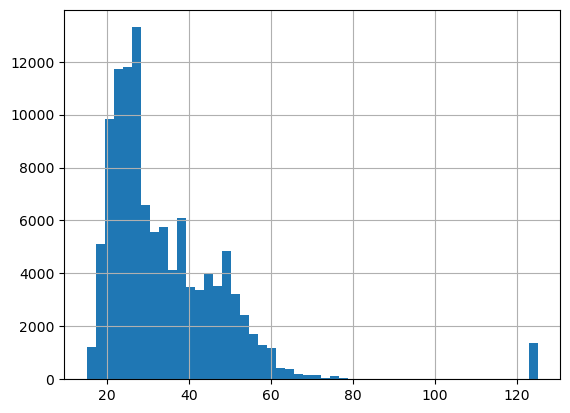

In [21]:
# we can take the table "vente_client" that we created at exercise 2

vente_client_2023 = vente_client[vente_client["DATE_ACHAT"].str[:4] == "2023"]

vente_client_2023.age.hist(bins = 50)

plt.show()

In [22]:
# Create age group 

bins = [0, 19, 29, 39, 49, 59, 69, 140]
labels = [ "Adolescents", "Jeunes adultes", "Adultes", "Adultes d'âge moyen", "Adultes mûrs", "Seniors jeunes", "Seniors"]

vente_client_2023["AgeGroup"]=pd.cut(vente_client_2023["age"], bins = bins, labels = labels, right = False)

C:\Users\you75\AppData\Local\Temp\ipykernel_5644\4246126098.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vente_client_2023["AgeGroup"]=pd.cut(vente_client_2023["age"], bins = bins, labels = labels, right = False)


In [23]:
pivot_table = vente_client_2023.groupby("AgeGroup").agg({"CATTC":"sum", "NUM_ACHAT":"nunique", "RCUCRM":"nunique", "MCVT":"count" })
pivot_table.columns=["somme CA", "total achat unique", "total client unique", "total articles"]
pivot_table = pivot_table.reset_index()

In [24]:
pivot_table["Panier moyen"] = pivot_table["somme CA"] / pivot_table["total achat unique"]
pivot_table["Fréquence d’achat"] = round(pivot_table["total achat unique"] / pivot_table["total client unique"], 2)
pivot_table["CA moyen"] = pivot_table["somme CA"] / pivot_table["total client unique"]
pivot_table["Nombre d’articles moyen au panier"] = round(pivot_table["total articles"] / pivot_table["total achat unique"], 2)

pivot_table[["AgeGroup", "Panier moyen", "Fréquence d’achat", "CA moyen", "Nombre d’articles moyen au panier"]]

,AgeGroup,Panier moyen,Fréquence d’achat,CA moyen,Nombre d’articles moyen au panier
0,Adolescents,30.089726,2.05,61.763122,2.85
1,Jeunes adultes,34.155843,2.10,71.829706,3.21
2,Adultes,38.932319,1.85,72.125689,3.58
3,Adultes d'âge moyen,37.855333,1.97,74.533519,3.47
4,Adultes mûrs,36.465257,2.05,74.787241,3.40
5,Seniors jeunes,31.832361,1.70,54.178256,2.96
6,Seniors,32.187411,1.85,59.657701,2.91


## 6. En 2023, quels sont les segments les plus fréquemment cross-sellés avec un achat contenant du NIGHTWEAR ? 

## Combien d’achats ne contenaient QUE du NIGHTWEAR ?

In [25]:
vente_2023 = vente[vente["DATE_ACHAT"].str[:4] == "2023"]

vente_produit2023 = vente_2023.merge(produit, on = "MCVT", how = "left")

vente_produit2023.head()

,RCUCRM,MCVT,SAISON_x,PLANT,CANAL,NUM_ACHAT,DATE_ACHAT,SEMAINE_ETAM,PAYS_ACHAT,CATTC,DATE_MONTH,SAISON_y,SEGMENT
0,33731521.0,654342121007,20230002,2483,MAG,20231221248302183651,2023-12-21,2023051,FR,19.99,12,20230002,NIGHTWEAR
1,33731521.0,654331966005,20230002,2483,MAG,20231221248302183652,2023-12-21,2023051,FR,15.99,12,20230002,NIGHTWEAR
2,33731521.0,654304457005,20230002,2483,MAG,20231221248302183652,2023-12-21,2023051,FR,6.99,12,20230002,DAYWEAR
3,33731521.0,654316057005,20230002,2483,MAG,20231221248302183652,2023-12-21,2023051,FR,6.99,12,20230002,DAYWEAR
4,20702856.0,653996363002,20230001,2182,MAG,20230519218256003403,2023-05-19,2023020,FR,24.99,05,20230002,NIGHTWEAR


In [84]:
order_nightwear = vente_produit2023.query('SEGMENT == "NIGHTWEAR"')[["NUM_ACHAT"]]

order_crosssale = vente_produit2023[vente_produit2023["NUM_ACHAT"].isin(order_nightwear["NUM_ACHAT"])].query('SEGMENT != "NIGHTWEAR"')

order_crosssale.SEGMENT.value_counts()

DAYWEAR    17809
MAN         2703
BEACH       1277
SPORT        202
Name: SEGMENT, dtype: int64

In [88]:
# Combien d’achats ne contenaient QUE du NIGHTWEAR ? 
# order_nightwear - order_crosssale

order_nightwear["NUM_ACHAT"].nunique() - order_crosssale["NUM_ACHAT"].nunique()

7949

## 7. Quel est le panier moyen des clients ayant réalisé 1 achat en 2023 vs 2+ achats ?

Panier moyen = somme CA / total achats uniques

In [31]:
vente_2023.head()

,RCUCRM,MCVT,SAISON,PLANT,CANAL,NUM_ACHAT,DATE_ACHAT,SEMAINE_ETAM,PAYS_ACHAT,CATTC,DATE_MONTH
4,33731521.0,654342121007,20230002,2483,MAG,20231221248302183651,2023-12-21,2023051,FR,19.99,12
5,33731521.0,654331966005,20230002,2483,MAG,20231221248302183652,2023-12-21,2023051,FR,15.99,12
6,33731521.0,654304457005,20230002,2483,MAG,20231221248302183652,2023-12-21,2023051,FR,6.99,12
7,33731521.0,654316057005,20230002,2483,MAG,20231221248302183652,2023-12-21,2023051,FR,6.99,12
39,20702856.0,653996363002,20230001,2182,MAG,20230519218256003403,2023-05-19,2023020,FR,24.99,05


In [49]:
pivot_table = vente_2023.groupby("RCUCRM").agg({"NUM_ACHAT" : "nunique"}).sort_values("NUM_ACHAT", ascending = False).reset_index()
client_un_achat = pivot_table.query("NUM_ACHAT == 1")["RCUCRM"]

vente_2023["1 or plusieurs achats"] = np.where(vente_2023.RCUCRM.isin(client_un_achat), "1 achat", "2+ achats")

C:\Users\you75\AppData\Local\Temp\ipykernel_5644\3259459798.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vente_2023["1 or plusieurs achats"] = np.where(vente_2023.RCUCRM.isin(client_un_achat), "1 achat", "2+ achats")


In [51]:
vente_2023["1 or plusieurs achats"].value_counts()

2+ achats    91526
1 achat      44246
Name: 1 or plusieurs achats, dtype: int64

In [57]:
compare_table = vente_2023.groupby("1 or plusieurs achats").agg({"CATTC" : "sum", "NUM_ACHAT" : "nunique"})
compare_table.columns = ["somme CA", "total achats uniques"]
compare_table["panier moyen"] = compare_table["somme CA"] / compare_table["total achats uniques"]
compare_table

,somme CA,total achats uniques,panier moyen
1 or plusieurs achats,,,
1 achat,474093.96,12875,36.822832
2+ achats,986661.63,28002,35.235399
